In [1]:
import os
import sys

sys.path.append('../')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import gridspec
from matplotlib.colors import LogNorm, Normalize
from torch.optim import Adam
from tqdm import tqdm

from kwave.ktransducer import kWaveGrid
from models.APACT import APACT
from models.DAS import DAS, DAS_dual
from models.Joint_Recon import Joint_Recon
from models.PACT import TF_PACT, Wavefront_SoS
from models.Wiener import Wiener_Batched
from utils.data import *
from utils.dataset import get_jr_dataloader
from utils.reconstruction import *
from utils.simulations import get_water_SoS
from utils.utils_torch import get_total_params
from utils.visualization import *

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = '../data/'
results_path = '../results/'

### Load in Sinogram

Successfully loaded data from "../data/ANIMAL_LAYER.mat".


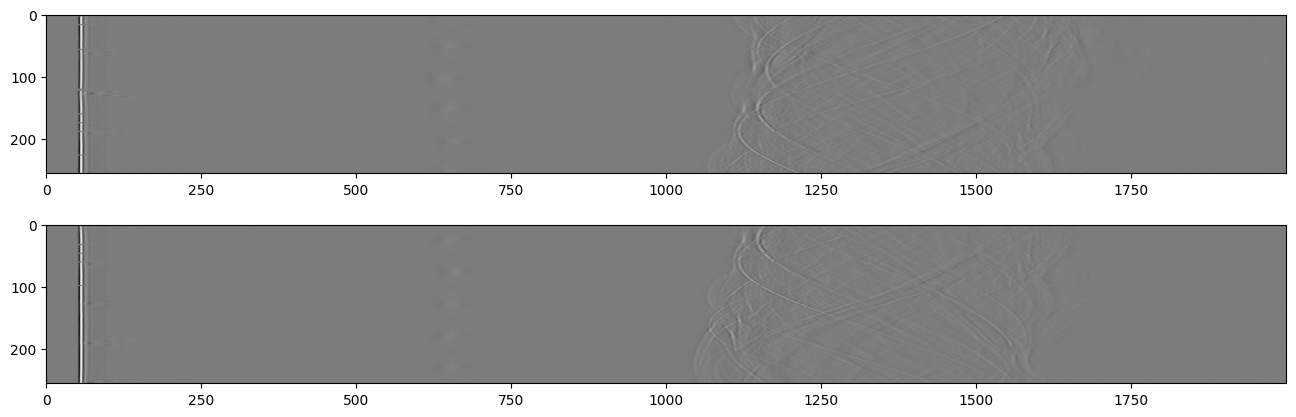

In [2]:
sinogram = load_mat(os.path.join(data_path, 'ANIMAL_LAYER.mat'))
sinogram1 = sinogram[128:128+256,:]
sinogram2 = sinogram[256:,:]
plt.figure(figsize=(16,5))
plt.subplot(2,1,1)
plt.imshow(sinogram1, cmap='gray')
plt.subplot(2,1,2)
plt.imshow(sinogram2, cmap='gray')
plt.show()

### Load and Deconvolve EIR

Successfully loaded data from "../data/EIR_TUNGSTEN.mat".


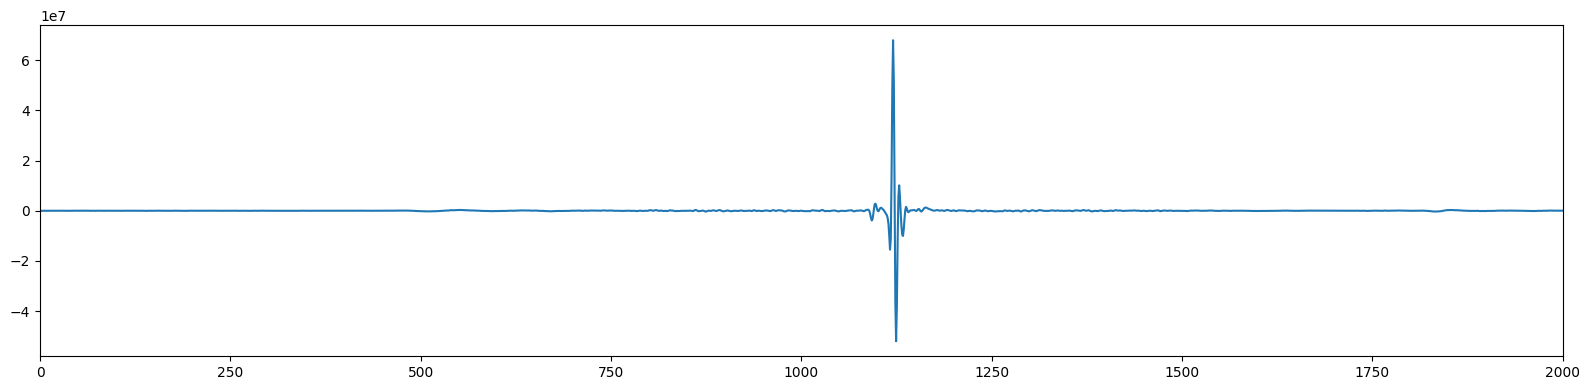

In [3]:
EIR = load_mat(os.path.join(data_path, 'EIR_TUNGSTEN.mat'))

time = np.linspace(0, 2000, 2000)
plt.figure(figsize=(16,4))
plt.plot(time, np.squeeze(EIR[:2000]))
plt.xlim(0, 2000)
plt.tight_layout()

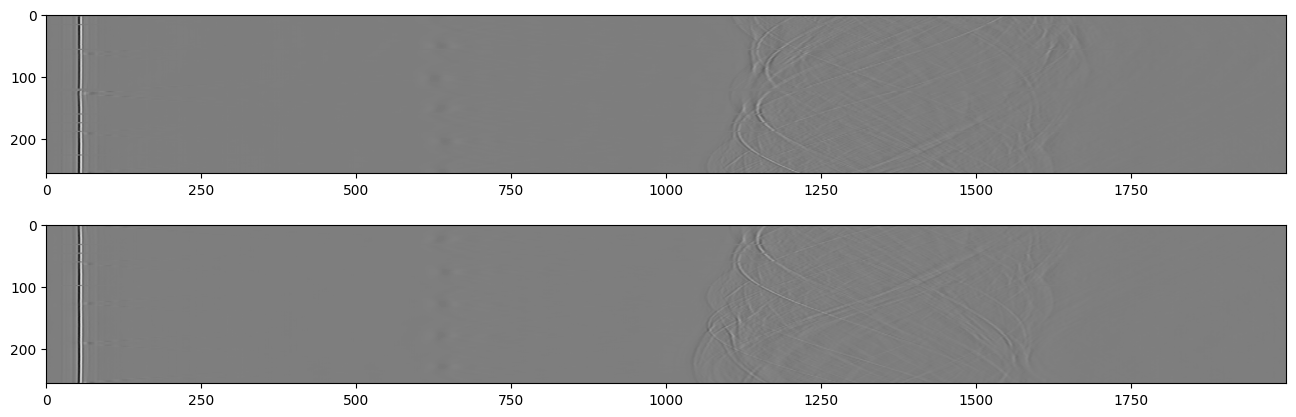

In [4]:
sinogram_deconv1 = deconvolve_sinogram(sinogram1, EIR)
sinogram_deconv2 = deconvolve_sinogram(sinogram2, EIR)

plt.figure(figsize=(16,5))
plt.subplot(2,1,1)
plt.imshow(sinogram_deconv1, cmap='gray')
plt.subplot(2,1,2)
plt.imshow(sinogram_deconv2, cmap='gray')
plt.show()

### Load Ring Error

Successfully loaded data from "../data/RING_ERROR_NEW.mat".
(256, 1) (256, 1)


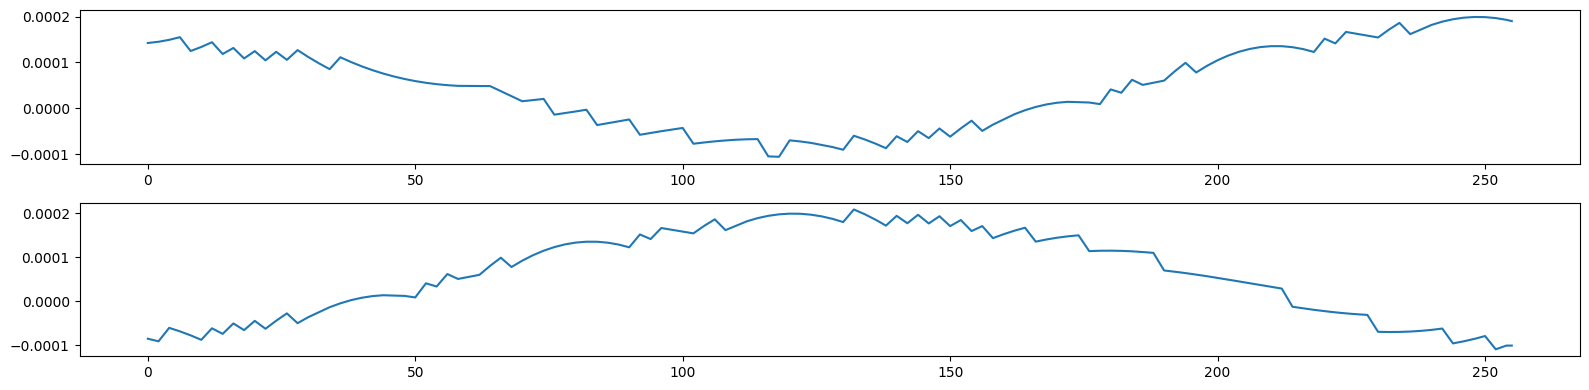

In [5]:
ring_error, transducer_theta = load_mat(os.path.join(data_path, 'RING_ERROR_NEW.mat'))
print(ring_error.shape, transducer_theta.shape)

idx = np.arange(0, 256, 1)
ring_error = np.interp(np.arange(0, 512, 1), np.arange(0, 512, 2), ring_error[:,0]) # Upsample ring error.
ring_error1, ring_error2 = ring_error[128:128+256], ring_error[256:]

plt.figure(figsize=(16,4))
plt.subplot(2,1,1)
plt.plot(idx, ring_error1)
plt.subplot(2,1,2)
plt.plot(idx, ring_error2)
plt.tight_layout()

### Preparations

First, we need to define the size and resolution of the image. We also calculate the X and Y coordinates of each pixels in the image.

In [6]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
x_c, y_c = -26, 15      # Offset of the invivo center w.r.t. the ring array center [pixels].
kgrid = kWaveGrid([Nx+80, Ny+80], [dx, dy])
x_vec, y_vec = kgrid.x_vec[x_c+40:x_c+Nx+40,:], kgrid.y_vec[y_c+40:y_c+Ny+40,:]
l = 3.2e-3              # Patch size [m].

In [7]:
R = 10.6e-3              # Radius of single body [m].
T = 31.0                # Water temperature [C].
v0 = get_water_SoS(T)   # Background SoS [m/s].
v1 = 1554.0             # Avergae SoS in single body [m/s].
print(v0, v1)

1511.4390936112618 1554.0


In [8]:
fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = torch.tensor(gaussian_kernel(sigma, 80)).to(device)

In [9]:
das1 = DAS(R_ring=0.05, N_transducer=256, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, angle_range=(0.5*torch.pi, 1.5*torch.pi), mode='zero')
das1.to(device)
das1.eval()

das2 = DAS(R_ring=0.05, N_transducer=256, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, angle_range=(torch.pi, 2*torch.pi), mode='zero')
das2.to(device)
das2.eval()

DAS()

### Conventional DAS

In [10]:
with torch.no_grad():
    rec_das1 = das1(sinogram=torch.tensor(sinogram_deconv1[:,46:], device=device), 
                   v0=torch.tensor(1515.0, device=device),
                   d_delay=torch.zeros(1, device=device),
                   ring_error=torch.tensor(ring_error1.reshape(-1,1,1), device=device)).detach().cpu().numpy()
    rec_das2 = das2(sinogram=torch.tensor(sinogram_deconv2[:,46:], device=device), 
                   v0=torch.tensor(1515.0, device=device),
                   d_delay=torch.zeros(1, device=device),
                   ring_error=torch.tensor(ring_error2.reshape(-1,1,1), device=device)).detach().cpu().numpy()

save_mat(os.path.join(results_path, 'das_invivo_half1.mat'), rec_das1.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'das_invivo_half2.mat'), rec_das2.swapaxes(0,1), 'img')

Successfully saved data to "../results/das_invivo_half1.mat".
Successfully saved data to "../results/das_invivo_half2.mat".


### Dual SoS DAS

In [11]:
das_dual1 = DAS_dual(R_ring=0.05, N_transducer=256, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, angle_range=(0.5*torch.pi, 1.5*torch.pi), R_body=R, center=(x_c*dx, y_c*dy), mode='zero')
das_dual1.to(device)
das_dual1.eval()

das_dual2 = DAS_dual(R_ring=0.05, N_transducer=256, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, angle_range=(torch.pi, 2*torch.pi), R_body=R, center=(x_c*dx, y_c*dy), mode='zero')
das_dual2.to(device)
das_dual2.eval()

DAS_dual()

In [12]:
with torch.no_grad():
    rec_das_dual1 = das_dual1(sinogram=torch.tensor(sinogram_deconv1[:,46:], device=device),
                              v0=torch.tensor(v0, device=device),
                              v1=torch.tensor(v1, device=device),
                              d_delay=torch.zeros(1, device=device), 
                              ring_error=torch.tensor(ring_error1.reshape(-1,1,1), device=device)).detach().cpu().numpy()
    rec_das_dual2 = das_dual2(sinogram=torch.tensor(sinogram_deconv2[:,46:], device=device),
                              v0=torch.tensor(v0, device=device),
                              v1=torch.tensor(v1, device=device),
                              d_delay=torch.zeros(1, device=device), 
                              ring_error=torch.tensor(ring_error2.reshape(-1,1,1), device=device)).detach().cpu().numpy()

In [13]:
save_mat(os.path.join(results_path, 'das_dual_invivo_half1.mat'), rec_das_dual1.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'das_dual_invivo_half2.mat'), rec_das_dual2.swapaxes(0,1), 'img')

Successfully saved data to "../results/das_dual_invivo_half1.mat".
Successfully saved data to "../results/das_dual_invivo_half2.mat".


### APACT

In [14]:
# delays_apact = np.arange(-8e-4, 8e-4, 0.5e-4) # Delay distances [m].

# apact = APACT(delays=delays_apact, dc_range=[-2e-4, 1.6e-4], amp=3.2e-4, step=4e-5, data_path='./TF_invivo_half/', device=device)
# apact.to(device)
# apact.eval()

In [15]:
# img_stack1, img_stack2 = [], []
# with torch.no_grad():
#     for d_delay in tqdm(delays_apact):
#         recon1 = das1(torch.tensor(sinogram_deconv1[:,46:], device=device), 
#                      torch.tensor(1515.0, device=device), 
#                      torch.tensor(d_delay, device=device), 
#                      torch.tensor(ring_error1.reshape(-1,1,1), device=device))
#         img_stack1.append(recon1)
#         recon2 = das2(torch.tensor(sinogram_deconv2[:,46:], device=device), 
#                      torch.tensor(1515.0, device=device), 
#                      torch.tensor(d_delay, device=device), 
#                      torch.tensor(ring_error2.reshape(-1,1,1), device=device))
#         img_stack2.append(recon2)
# img_stack1 = torch.stack(img_stack1, dim=0)
# img_stack2 = torch.stack(img_stack2, dim=0)

In [16]:
# def deconv_full_apact(model, img_stack, gaussian_window):
#     rec_apact = torch.zeros_like(img_stack[0], device=device)
#     with torch.no_grad():
#         for idx in tqdm(range(625)):
#             i, j = idx // 25, idx % 25
#             obs = img_stack[:,20*i:20*i+80, 20*j:20*j+80] * gaussian_window
#             obs = obs.unsqueeze(0).to(device)
#             rec, _, _, _ = model(obs)
#             rec_apact[20*i:20*i+80, 20*j:20*j+80] += rec.squeeze(0).squeeze(0)
#     return rec_apact.detach().cpu().numpy()

# # rec_apact1 = deconv_full_apact(apact, img_stack1, gaussian_window)
# rec_apact2 = deconv_full_apact(apact, img_stack2, gaussian_window)

In [17]:
# save_mat(os.path.join(results_path, 'apact_invivo_half1.mat'), rec_apact1.swapaxes(0,1), 'img')
# save_mat(os.path.join(results_path, 'apact_invivo_half2.mat'), rec_apact2.swapaxes(0,1), 'img')

### Joint Reconstruction

In [18]:
n_delays = 32
# delays = get_delays(R, v0, v1, n_delays, 'uniform')
delays = np.linspace(-8e-4, 8e-4, n_delays)

img_stack1, img_stack2 = [], []
with torch.no_grad():
    for d_delay in tqdm(delays):
        recon1 = das1(torch.tensor(sinogram_deconv1[:,46:], device=device), 
                      torch.tensor(v0, device=device), 
                      torch.tensor(d_delay, device=device), 
                      torch.tensor(ring_error1.reshape(-1,1,1), device=device))
        img_stack1.append(recon1)
        recon2 = das2(torch.tensor(sinogram_deconv2[:,46:], device=device), 
                      torch.tensor(v0, device=device), 
                      torch.tensor(d_delay, device=device), 
                      torch.tensor(ring_error2.reshape(-1,1,1), device=device))
        img_stack2.append(recon2)
img_stack1 = torch.stack(img_stack1, dim=0)
img_stack2 = torch.stack(img_stack2, dim=0)

100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


In [19]:
img_stack1 = (img_stack1 - img_stack1.mean()) / img_stack1.std()
data_loader = get_jr_dataloader(img_stack1, l)

kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec

In [20]:
joint_recon1 = Joint_Recon(mode='SIREN', mean=1537.0, std=27.0, lam_tv=0.0e-3,
                          x_vec=x_vec, y_vec=y_vec, R=R, v0=v0, n_points=80, l=3.2e-3, n_delays=n_delays, angle_range=(1.5*torch.pi, 0.5*torch.pi))
joint_recon1.to(device)
print("Number of parameter: %s" % (get_total_params(joint_recon1)))

optimizer1 = Adam(params=joint_recon1.parameters(), lr=1.e-5)

Number of parameter: 17025


In [21]:
n_epochs = 50
loss_list = []
for epoch in range(n_epochs):
    joint_recon1.train()
    train_loss = 0.0
    for x, y, img in data_loader:
        x, y, img = x.to(device), y.to(device), img.to(device)
        rec_jr, SoS_jr1, loss = joint_recon1(x, y, img, torch.tensor(delays).to(device))
        
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        train_loss += loss.item()
    loss_list.append(train_loss)
    print("Joint Reconstruction:  [{}/{}]  loss={:0.4g} ".format(epoch+1, n_epochs, train_loss/len(data_loader)))

Joint Reconstruction:  [1/50]  loss=nan 
Joint Reconstruction:  [2/50]  loss=nan 
Joint Reconstruction:  [3/50]  loss=nan 
Joint Reconstruction:  [4/50]  loss=nan 
Joint Reconstruction:  [5/50]  loss=nan 
Joint Reconstruction:  [6/50]  loss=nan 
Joint Reconstruction:  [7/50]  loss=nan 
Joint Reconstruction:  [8/50]  loss=nan 
Joint Reconstruction:  [9/50]  loss=nan 
Joint Reconstruction:  [10/50]  loss=nan 
Joint Reconstruction:  [11/50]  loss=nan 
Joint Reconstruction:  [12/50]  loss=nan 
Joint Reconstruction:  [13/50]  loss=nan 
Joint Reconstruction:  [14/50]  loss=nan 
Joint Reconstruction:  [15/50]  loss=nan 
Joint Reconstruction:  [16/50]  loss=nan 
Joint Reconstruction:  [17/50]  loss=nan 
Joint Reconstruction:  [18/50]  loss=nan 
Joint Reconstruction:  [19/50]  loss=nan 
Joint Reconstruction:  [20/50]  loss=nan 
Joint Reconstruction:  [21/50]  loss=nan 
Joint Reconstruction:  [22/50]  loss=nan 
Joint Reconstruction:  [23/50]  loss=nan 
Joint Reconstruction:  [24/50]  loss=nan 
J

In [ ]:
SoS_jr1 = SoS_jr1.detach().cpu().numpy()

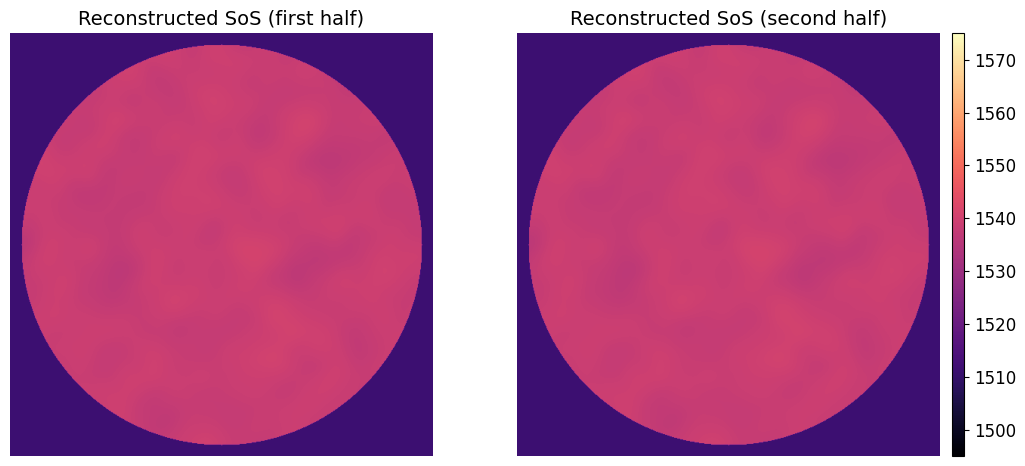

In [ ]:
fig = plt.figure(figsize=(12, 6))
norm_sos = Normalize(vmax=1575, vmin=1495)

ax = plt.subplot(1, 2, 1)
plt.title('Reconstructed SoS (first half)', fontsize=14)
plt.imshow(SoS_jr1, norm=norm_sos, cmap='magma')
plt.axis('off')

ax = plt.subplot(1, 2, 2)
plt.title('Reconstructed SoS (second half)', fontsize=14)
plt.imshow(SoS_jr1, norm=norm_sos, cmap='magma')
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.01, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm_sos)
# cb.ax.set_yticks([1500, 1510, 1520, 1530])
cb.ax.tick_params(labelsize=12)

In [ ]:
SoS_jr1.mean(), SoS_jr1.std(), SoS_jr1.max(), SoS_jr1.min()

(1530.6227215784074, 12.47276366411595, 1540.8346828818321, 1511.4390936112618)

### Deconvolution with Single Body PSFs

In [ ]:
# kgrid = kWaveGrid([Nx, Ny], [dx, dy])
# XX, YY = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())
# SoS = np.ones((Ny, Nx)) * v0
# SoS[XX**2 + YY**2 < R**2] = 1570

In [ ]:
def deconv_full(img_stack, SoS, gaussian_window, delays, angle_range, attention='uniform'):
    wavefront_sos = Wavefront_SoS(R, v0, x_vec, y_vec, n_points=180)
    wavefront_sos.to(device)
    wavefront_sos.eval()
    
    tf_pact = TF_PACT(n_points=160, l=6.4e-3, n_delays=delays.shape[0], angle_range=angle_range)
    tf_pact.to(device)
    tf_pact.eval()

    wiener = Wiener_Batched(lam=0.e-3, order=1.2)
    wiener.to(device)
    wiener.eval()
    
    img_stack /= img_stack.abs().mean()
    rec_full = torch.zeros_like(img_stack[0]).to(device)
    SoS = torch.tensor(SoS, dtype=torch.float64).to(device)
    with torch.no_grad():
        for idx in tqdm(range(25**2)):
            i, j = idx // 25, idx % 25
            x, y = (j-12)*l / 4, (12-i)*l / 4
            thetas, wfs = wavefront_sos(torch.tensor(x).to(device), torch.tensor(y).to(device), SoS)
            tf = tf_pact(torch.tensor(delays).to(device).view(1,-1,1,1), thetas, wfs)
            obs = img_stack[:,20*i:20*i+80, 20*j:20*j+80]
            _, C0 = get_r_C0(i, j, R, l, v0, v1)
            weights = torch.tensor(get_weights(C0, delays, attention)).to(device)
            obs, tf = obs * torch.sqrt(weights), tf * torch.sqrt(weights) # Apply attention weights to different channels.
            obs = obs.unsqueeze(0) * gaussian_window
            rec = wiener(obs, tf)
            rec_full[20*i:20*i+80, 20*j:20*j+80] += rec.squeeze(0).squeeze(0)
    return rec_full.detach().cpu().numpy()

# rec_deconv1 = deconv_full(img_stack1, SoS, gaussian_window, delays, angle_range=(0.5*torch.pi, 1.5*torch.pi))
rec_jr1 = deconv_full(img_stack1, SoS_jr1, gaussian_window, delays, angle_range=(0.5*torch.pi, 1.5*torch.pi))

100%|██████████| 625/625 [00:02<00:00, 221.07it/s]


In [ ]:
save_mat(os.path.join(results_path, 'jr_half.mat'), rec_jr1.swapaxes(0,1), 'img')
# save_mat(os.path.join(results_path, 'sb_wiener_invivo_half1.mat'), rec_wiener1.swapaxes(0,1), 'img')
# save_mat(os.path.join(results_path, 'sb_wiener_invivo_half2.mat'), rec_wiener2.swapaxes(0,1), 'img')
# save_mat(os.path.join(results_path, 'sb_wiener_onehot_invivo_half1.mat'), rec_wiener_onehot1.swapaxes(0,1), 'img')
# save_mat(os.path.join(results_path, 'sb_wiener_onehot_invivo_half2.mat'), rec_wiener_onehot2.swapaxes(0,1), 'img')
# save_mat(os.path.join(results_path, 'sb_admm_invivo.mat'), rec_admm.swapaxes(0,1), 'img')

Successfully saved data to "../results/jr_half.mat".


### Visualization

Load and normalize images.

In [ ]:
rec_das1 = load_mat(os.path.join(results_path, 'das_invivo_half1.mat'))
rec_das2 = load_mat(os.path.join(results_path, 'das_invivo_half2.mat'))
rec_das_dual1 = load_mat(os.path.join(results_path, 'das_dual_invivo_half1.mat'))
rec_das_dual2 = load_mat(os.path.join(results_path, 'das_dual_invivo_half2.mat'))
rec_apact1 = load_mat(os.path.join(results_path, 'apact_invivo_half1.mat'))
rec_apact2 = load_mat(os.path.join(results_path, 'apact_invivo_half2.mat'))
rec_wiener1 = load_mat(os.path.join(results_path, 'sb_wiener_invivo_half1.mat'))
rec_wiener2 = load_mat(os.path.join(results_path, 'sb_wiener_invivo_half2.mat'))  
rec_wiener_onehot1 = load_mat(os.path.join(results_path, 'sb_wiener_onehot_invivo_half1.mat'))
rec_wiener_onehot2 = load_mat(os.path.join(results_path, 'sb_wiener_onehot_invivo_half2.mat'))
# rec_admm = load_mat(os.path.join(results_path, 'sb_admm_invivo.mat'))

Successfully loaded data from "../results/das_invivo_half1.mat".
Successfully loaded data from "../results/das_invivo_half2.mat".
Successfully loaded data from "../results/das_dual_invivo_half1.mat".
Successfully loaded data from "../results/das_dual_invivo_half2.mat".
Successfully loaded data from "../results/apact_invivo_half1.mat".
Successfully loaded data from "../results/apact_invivo_half2.mat".
Successfully loaded data from "../results/sb_wiener_invivo_half1.mat".
Successfully loaded data from "../results/sb_wiener_invivo_half2.mat".
Successfully loaded data from "../results/sb_wiener_onehot_invivo_half1.mat".
Successfully loaded data from "../results/sb_wiener_onehot_invivo_half2.mat".


In [ ]:
[rec_das1, rec_das2, rec_das_dual1, rec_das_dual2, rec_apact1, rec_apact2, \
 rec_wiener1, rec_wiener2, rec_wiener_onehot1, rec_wiener_onehot2, rec_jr1] = \
    [standardize(img) for img in [rec_das1, rec_das2, rec_das_dual1, rec_das_dual2, rec_apact1, rec_apact2, \
                                  rec_wiener1, rec_wiener2, rec_wiener_onehot1, rec_wiener_onehot2, rec_jr1]]

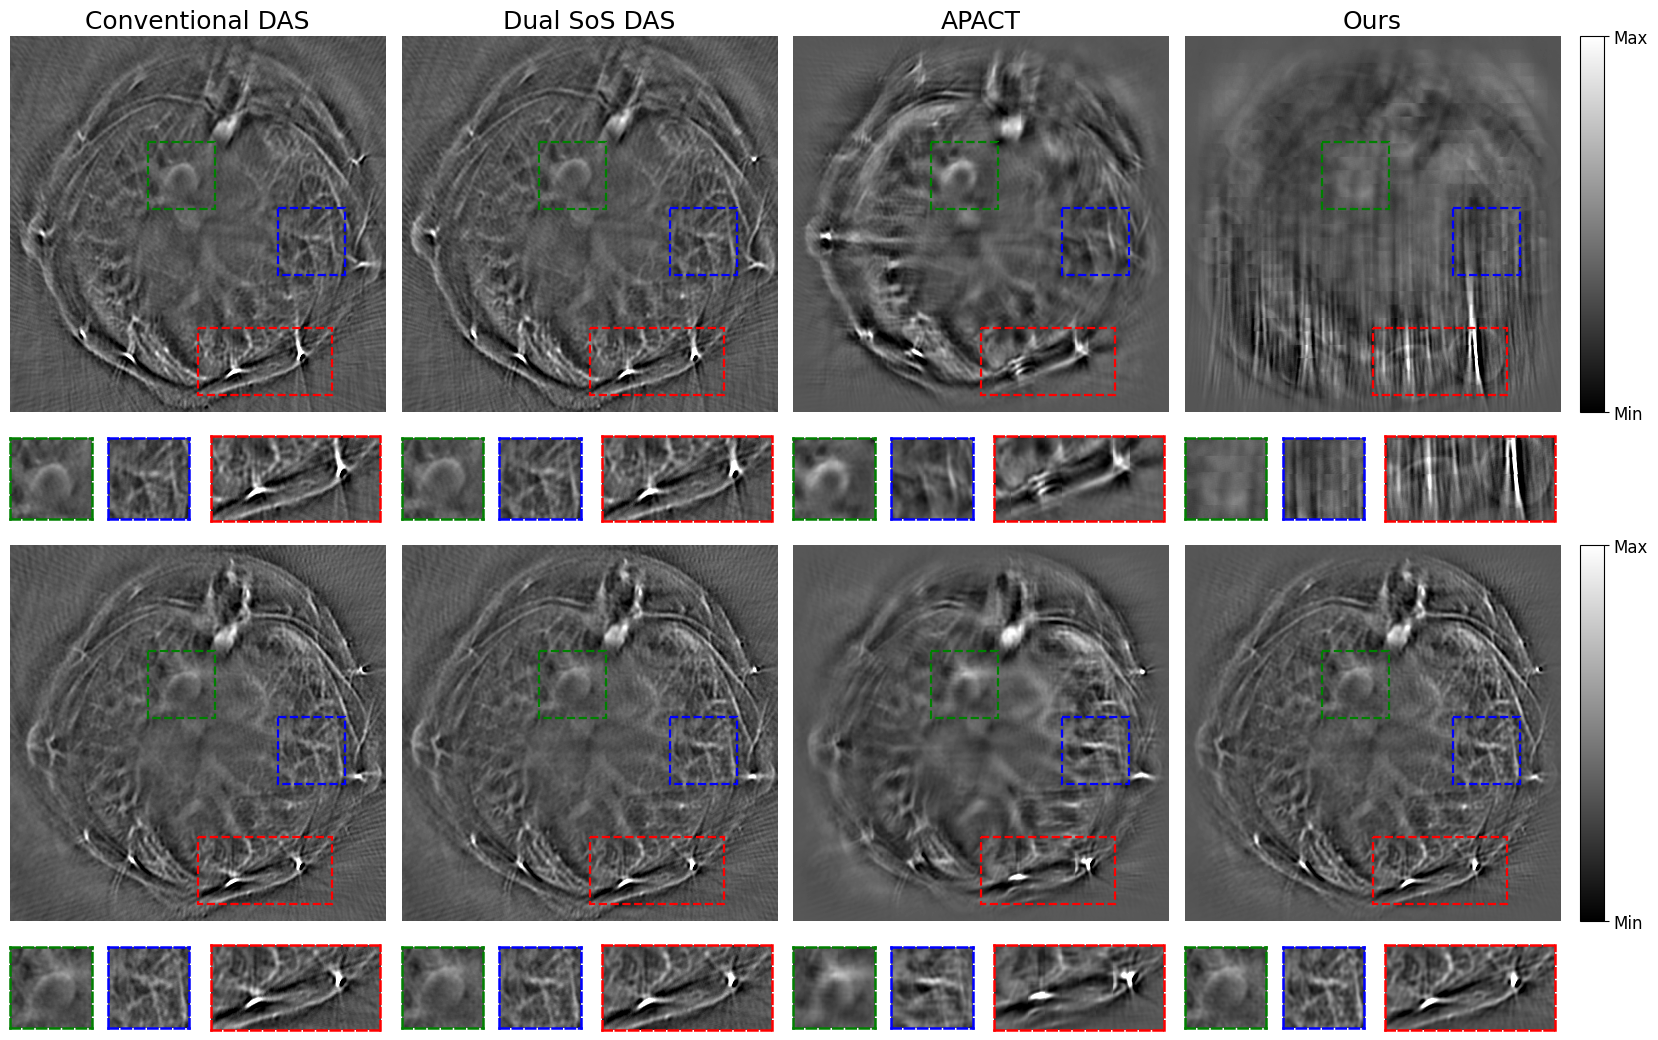

In [ ]:
patches = [(157, 205, 100, 100, 'green'), (255, 400, 100, 100,'blue'), (435, 280, 100, 200, 'red')]

fig = plt.figure(figsize=(20, 13))
gs = gridspec.GridSpec(10, 16)
norm = matplotlib.colors.Normalize(vmax=7, vmin=-3.5)
methods = ['Conventional DAS', 'Dual SoS DAS', 'APACT', 'Ours']
for idx, rec_full in enumerate([rec_das1, rec_das_dual1, rec_apact1, rec_jr1, rec_das2, rec_das_dual2, rec_apact2, rec_wiener2]):
    ax = plt.subplot(gs[5*(idx//4):5*(idx//4)+4,(idx%4)*4:(idx%4+1)*4])
    plt.imshow(rec_full, cmap='gray', norm=norm)
    if idx < 4:
        plt.title(methods[idx], fontsize=18)
    plt.axis('off')
    for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[5*(idx//4)+4:5*(idx//4+1),(idx%4)*4+k:(idx%4)*4+k+1+(k==2)])
        plt.imshow(rec_full[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(1.8)
            ax2.spines[loc].set_linestyle('--')
    if idx % 4 == 3:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm)
        cb.set_ticks(ticks=[-3.5, 7], labels=['Min', 'Max'], fontsize=12)

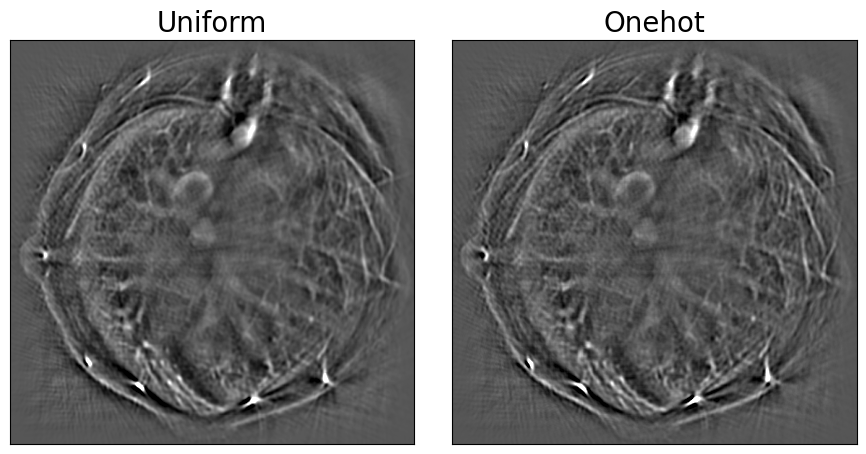

In [ ]:
fig = plt.figure(figsize=(9, 4.5))
for idx, (rec_full, attention) in enumerate(zip([rec_wiener1, rec_wiener_onehot1], ['Uniform', 'Onehot'])):
        ax = plt.subplot(1,2,idx+1)
        plt.imshow(rec_full, cmap='gray', norm=norm)
        plt.title(attention, fontsize=20)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()